# Прогнозирование стоимости недвижимости в зависимости от различных факторов и параметров. Разработка модели и анализ рынка.

### Бизнес-проблема  

На рынке недвижимости существует потребность в объективной и быстрой оценке стоимости жилья. Многие специалисты до сих пор опираются на свои субъективные представления, что не всегда позволяет учесть все влияющие факторы и может приводить к завышенным или заниженным ценам.

### Цель проекта  

На основании данных об объектах недвижимости в Москве и Московской обалсти необходимо:
1. Провести разведывательный анализ данных, чтобы выявить основные факторы, влияющие на стоимость квартир.
2. Построить модель машинного обучения, способную прогнозировать цену типовых квартир (массового сегмента рынка) на основании их характеристик.
3. Оценить точность модели и сформулировать рекомендации для бизнеса на основе полученных результатов: какие факторы стоит учитывать при ценообразовании и на какие объекты обратить внимание.

### Данные  

Датасет Moscow Housing Price Dataset содержит объявления о продаже квартир в Москве и Московской области, собранные в ноябре 2023 года.  
Этот набор данных был загружен на Kaggle: https://www.kaggle.com/datasets/egorkainov/moscow-housing-price-dataset/data.

Данные содержат информацию о характеристиках квартир и условиях продажи — таких как расположение, площадь, этажность, тип жилья и уровень ремонта. Целевой признак — цена квартиры.

### Ожидаемый результат  

Итогом проекта станет:
- Набор выявленных закономерностей рынка
- Обученная регрессионная модель, выдающая приблизительную цену типичных квартир
- Рекомендации для бизнеса, как можно использовать модель в работе

## 1. Импорт библиотек

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, kendalltau, mannwhitneyu
import phik

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    root_mean_squared_error,
    mean_absolute_percentage_error
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import category_encoders as ce 

from catboost import CatBoostRegressor
import shap

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
pd.set_option('display.float_format', '{:,.2f}'.format)

## 2. Загрузка и подготовка данных

Посмотрим на первые строки датасета, чтобы понять его структуру и содержимое.

In [10]:
df = pd.read_csv('data.csv')
df.head()

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,"6,300,000.00",Secondary,Опалиха,6.00,Moscow region,1.00,30.60,11.10,8.50,25.00,25,Cosmetic
1,"9,000,000.00",Secondary,Павшино,2.00,Moscow region,1.00,49.20,20.00,10.00,6.00,15,European-style renovation
2,"11,090,000.00",Secondary,Мякинино,14.00,Moscow region,1.00,44.70,16.20,13.10,10.00,25,Cosmetic
3,"8,300,000.00",Secondary,Строгино,8.00,Moscow region,1.00,35.10,16.00,11.00,12.00,33,European-style renovation
4,"6,450,000.00",Secondary,Опалиха,6.00,Moscow region,1.00,37.70,15.20,4.00,5.00,5,Without renovation


In [13]:
df.shape

(22676, 12)

In [15]:
df.dtypes

Price               float64
Apartment type       object
Metro station        object
Minutes to metro    float64
Region               object
Number of rooms     float64
Area                float64
Living area         float64
Kitchen area        float64
Floor               float64
Number of floors      int64
Renovation           object
dtype: object

In [17]:
df.isna().mean()

Price              0.00
Apartment type     0.00
Metro station      0.00
Minutes to metro   0.00
Region             0.00
Number of rooms    0.00
Area               0.00
Living area        0.00
Kitchen area       0.00
Floor              0.00
Number of floors   0.00
Renovation         0.00
dtype: float64

На данном этапе мы видим, что у нас есть как числовые, так и категориальные переменные. Все в датасете около 22 тыс. объектов.
Некоторые числовые переменные представлены в виде целого числа, а некоторые в виде вещественных. Пропуски в данных отсутствуют.

## 3. Очистка и преобразование
1. Приводим названия колонок к единому стилю
2. Преобразуем колонки, содержащие только целые числа, к типу int
3. Ищем и удаляем дубликаты
4. Исправляем ошибки в названиях станций метро

#### 3.1 Приводим названия колонок к единому удобному формату, чтобы облегчить работу с данными и кодом.

In [22]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.head(3)

,price,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,"6,300,000.00",Secondary,Опалиха,6.00,Moscow region,1.00,30.60,11.10,8.50,25.00,25,Cosmetic
1,"9,000,000.00",Secondary,Павшино,2.00,Moscow region,1.00,49.20,20.00,10.00,6.00,15,European-style renovation
2,"11,090,000.00",Secondary,Мякинино,14.00,Moscow region,1.00,44.70,16.20,13.10,10.00,25,Cosmetic


#### 3.2 Преобразование типов данных

Приводим колонки, которые содержат целые числа, к типу int, чтобы убрать лишние десятичные нули
и сделать данные более корректными для анализа, при этом оставляя вещественные числа там, где дробная часть важна.

In [26]:
df[['price', 'minutes_to_metro', 'number_of_rooms', 'floor']] = df[['price', 'minutes_to_metro', 'number_of_rooms', 'floor']].astype('int')
df.head(3)

,price,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,6300000,Secondary,Опалиха,6,Moscow region,1,30.60,11.10,8.50,25,25,Cosmetic
1,9000000,Secondary,Павшино,2,Moscow region,1,49.20,20.00,10.00,6,15,European-style renovation
2,11090000,Secondary,Мякинино,14,Moscow region,1,44.70,16.20,13.10,10,25,Cosmetic


#### 3.4 Поиск и удаление дубликатов

Проверяем, есть ли полные дубликаты объявлений и удаляем их, так как они не несут новой информации.

In [36]:
df.duplicated().sum()

np.int64(1835)

In [38]:
df.loc[df.duplicated(keep=False), :].sort_values('price')

,price,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
17951,1939125,New building,Алма-Атинская,13,Moscow region,0,16.97,10.70,8.00,14,16,Cosmetic
18013,1939125,New building,Алма-Атинская,13,Moscow region,0,16.97,10.70,8.00,14,16,Cosmetic
15607,2278998,New building,Алма-Атинская,12,Moscow region,0,17.30,10.90,8.10,5,16,Cosmetic
15627,2278998,New building,Алма-Атинская,12,Moscow region,0,17.30,10.90,8.10,5,16,Cosmetic
17927,2583125,New building,Алма-Атинская,13,Moscow region,0,23.75,14.10,8.60,2,16,Cosmetic
...,...,...,...,...,...,...,...,...,...,...,...,...
845,855000000,Secondary,Ломоносовский проспект,19,Moscow,6,427.50,20.00,42.00,9,9,Without renovation
2614,885000000,Secondary,Ломоносовский проспект,19,Moscow,6,514.00,20.00,49.20,9,9,Without renovation
848,885000000,Secondary,Ломоносовский проспект,19,Moscow,6,514.00,20.00,49.20,9,9,Without renovation
933,1200000000,Secondary,Баррикадная,11,Moscow,6,630.00,300.00,100.00,6,7,Without renovation


In [42]:
df = df.drop_duplicates()

In [44]:
len(df)

20841

#### 3.5 Исправление ошибок в названиях станций метро

In [47]:
df['metro_station'].nunique()

547

Удаляем лишние пробелы и приводим названия станций метро к единому формату.

In [50]:
df['metro_station'].unique()[:20]

array([' Опалиха', ' Павшино', ' Мякинино', ' Строгино', ' Нахабино',
       ' Красногорская', ' Тушинская', ' Аникеевка', ' Волоколамская',
       ' Пенягино', ' Митино', ' Пятницкое шоссе', ' Чеховская',
       ' Арбатская', ' Фили', ' Белорусская', ' Кропоткинская',
       ' Спортивная', ' Алексеевская', ' Ростокино'], dtype=object)

In [52]:
df['metro_station'] = df['metro_station'].str.lower().str.strip()

In [54]:
df['metro_station'].nunique()

310

После стандартизации названий станций метро количество уникальных значений уменьшилось с 547 до 310, что показывает, как очистка устранила дубликаты из-за лишних пробелов.

## 4. Исследовательский анализ данных
1. Общая оценка датасета
2. Анализ целевой переменной
3. Исследование признаков
4. Корреляции
5. Сегментации
6. Анализ выбросов

### 4.1 Общая оценка датасета

In [59]:
df.describe()

,price,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors
count,"20,841.00","20,841.00","20,841.00","20,841.00","20,841.00","20,841.00","20,841.00","20,841.00"
mean,"34,037,767.21",11.95,2.04,69.71,37.49,12.42,9.18,16.59
std,"79,621,977.47",6.26,1.49,64.22,35.99,7.54,7.48,9.61
min,"1,150,000.00",0.00,0.00,6.00,2.00,1.00,1.00,1.00
25%,"7,089,768.00",7.00,1.00,37.16,17.50,8.50,4.00,11.00
50%,"11,471,120.00",11.00,2.00,52.60,28.40,10.60,8.00,16.00
75%,"23,550,000.00",15.00,3.00,75.50,43.00,14.30,13.00,20.00
max,"2,455,020,000.00",60.00,12.00,"1,117.00",566.80,122.00,92.00,97.00


In [61]:
df.describe(include=['object'])

,apartment_type,metro_station,region,renovation
count,20841,20841,20841,20841
unique,2,310,2,4
top,Secondary,красногвардейская,Moscow,Cosmetic
freq,12227,2418,14773,11806


#### Выводы описательной статистики

1. Средняя цена квартиры составляет 34 037 767 рублей, медианная — 11 471 120 рублей.  
   Разница между средним и медианой указывает на наличие выбросов в данных.

2. Средняя площадь квартиры — 69,7 м2, медианная — 52,6 м2.  
   Это также говорит о присутствии квартир с экстремально большой площадью.

3. Минимальные и максимальные значения признаков показывают редкие случаи:  
   - `price` варьируется от 1 150 000 до 2 455 020 000 рублей  
   - `minutes_to_metro` иногда равно 0  
   - `number_of_rooms` иногда равно 0  

   Эти значения могут быть реальными, но крайне редкими и отличаются от большинства наблюдений.

4. Категориальные признаки в целом сбалансированы, но некоторые категории встречаются чаще остальных (например, большинство квартир — Secondary, основной регион — Moscow, ремонт — Cosmetic).

Исходя из этого, данные содержат выбросы, которые важно учитывать при дальнейшем анализе, но они не обязательно являются ошибками.

#### 4.2 Анализ целевой переменной `price`

In [66]:
df['price'].describe()

count          20,841.00
mean       34,037,767.21
std        79,621,977.47
min         1,150,000.00
25%         7,089,768.00
50%        11,471,120.00
75%        23,550,000.00
max     2,455,020,000.00
Name: price, dtype: float64

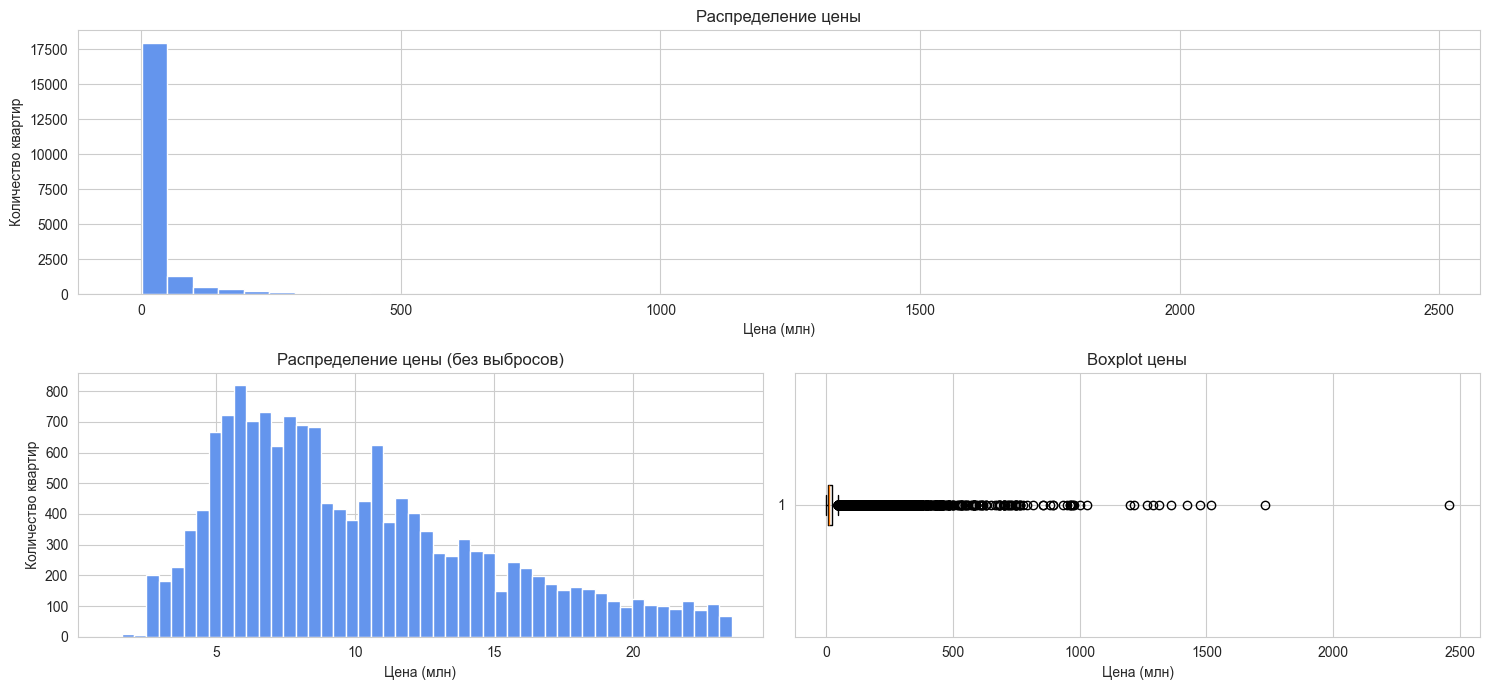

In [68]:
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(2, 2)  

ax1 = fig.add_subplot(gs[0, :])
ax1.hist(df['price'] / 1e6, bins=50, color='cornflowerblue')
ax1.set_title('Распределение цены')
ax1.set_xlabel('Цена (млн)')
ax1.set_ylabel('Количество квартир')

q75 = df['price'].quantile(0.75)
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(df[df['price'] <= q75]['price'] / 1e6, bins=50, color='cornflowerblue')
ax2.set_title('Распределение цены (без выбросов)')
ax2.set_xlabel('Цена (млн)')
ax2.set_ylabel('Количество квартир')

ax3 = fig.add_subplot(gs[1, 1])
ax3.boxplot(df['price'] / 1e6, vert=False) 
ax3.set_title('Boxplot цены')
ax3.set_xlabel('Цена (млн)')

plt.tight_layout()

На графике видно большое количество экстремальных значений.  
Основная масса квартир сосредоточена примерно в диапазоне **от 2 до 24 млн**, что отражает типичные цены на рынке.  
Хвост вправо отражает редкие, крайне дорогие объекты, которые значительно превышают цены основной массы квартир.  
Гистограмма без выбросов наглядно демонстрирует ядро распределения, а boxplot с выбросами показывает разброс цен и наличие экстремальных значений.  

#### 4.3 Исследование признаков

##### Числовые признаки

In [73]:
df['area'].describe()

count   20,841.00
mean        69.71
std         64.22
min          6.00
25%         37.16
50%         52.60
75%         75.50
max      1,117.00
Name: area, dtype: float64

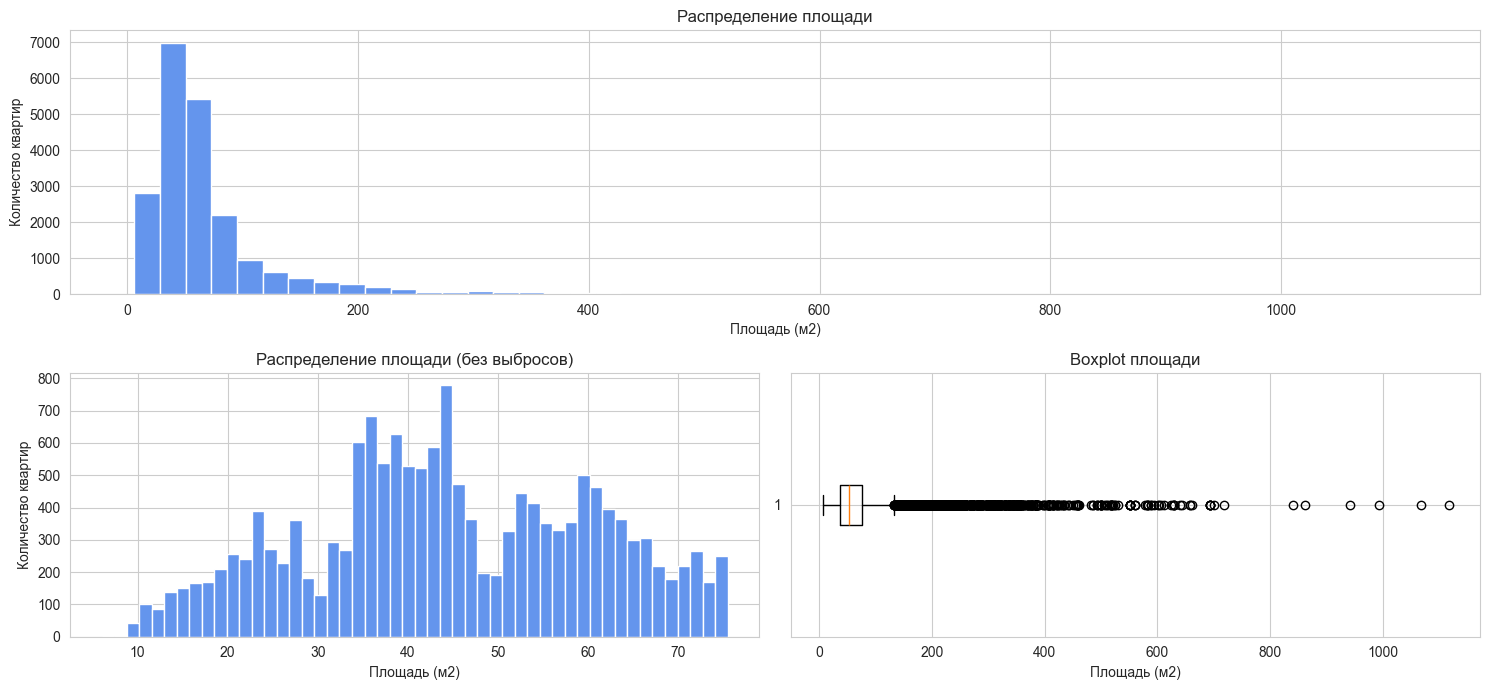

In [77]:
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(2, 2)  

ax1 = fig.add_subplot(gs[0, :])
ax1.hist(df['area'], bins=50, color='cornflowerblue')
ax1.set_title('Распределение площади')
ax1.set_xlabel('Площадь (м2)')
ax1.set_ylabel('Количество квартир')

q75 = df['area'].quantile(0.75)
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(df[df['area'] <= q75]['area'], bins=50, color='cornflowerblue')
ax2.set_title('Распределение площади (без выбросов)')
ax2.set_xlabel('Площадь (м2)')
ax2.set_ylabel('Количество квартир')

ax3 = fig.add_subplot(gs[1, 1])
ax3.boxplot(df['area'], vert=False) 
ax3.set_title('Boxplot площади')
ax3.set_xlabel('Площадь (м2)')

plt.tight_layout()

Здесь мы, так же как и с ценой, видим, что многие значения площади являются экстремальными, что формирует длинный правый хвост. Основная масса квартир сосредоточена примерно до **75 м2**, что отражает типичный размер жилья на рынке.

In [80]:
print(f'Минуты до метро:\n{df["minutes_to_metro"].describe()}\n')
print(f'Количество комнат:\n{df["number_of_rooms"].describe()}')

Минуты до метро:
count   20,841.00
mean        11.95
std          6.26
min          0.00
25%          7.00
50%         11.00
75%         15.00
max         60.00
Name: minutes_to_metro, dtype: float64

Количество комнат:
count   20,841.00
mean         2.04
std          1.49
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         12.00
Name: number_of_rooms, dtype: float64


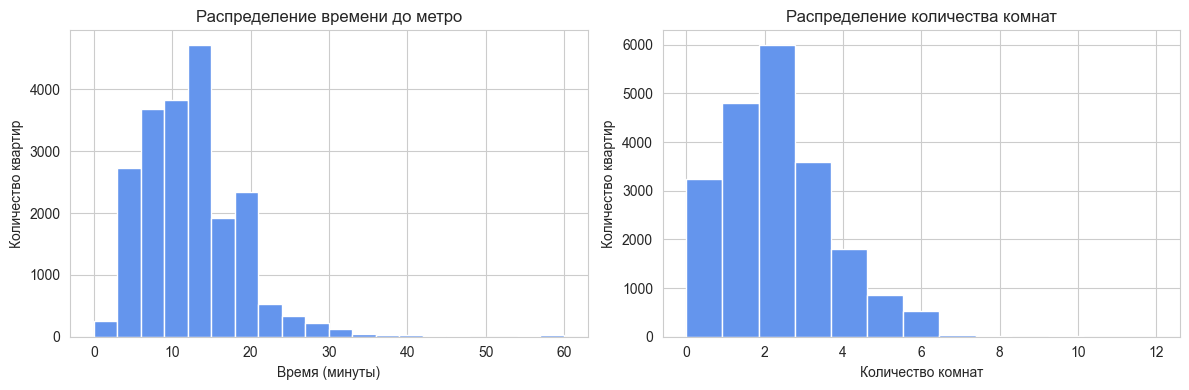

In [82]:
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 2)  

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(df['minutes_to_metro'], bins=20, color='cornflowerblue')
ax1.set_title('Распределение времени до метро')
ax1.set_xlabel('Время (минуты)')
ax1.set_ylabel('Количество квартир')

ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df['number_of_rooms'], bins=13, color='cornflowerblue')
ax2.set_title('Распределение количества комнат')
ax2.set_xlabel('Количество комнат')
ax2.set_ylabel('Количество квартир')

plt.tight_layout()

Далее мы отобрали те числовые переменные, которые могут оказывать наибольшее влияние на цену: `minutes_to_metro` и `number_of_rooms`.

- `minutes_to_metro`: основная масса квартир расположена в пределах **7–15 минут**. Есть редкие квартиры с временем до метро до **60 минут**, что является выбросами, но может отражать реальные объекты.
- `number_of_rooms`: большинство квартир имеет **1–3** комнаты. В данных встречаются квартиры с **0** комнат (вероятно, студии) и редкие квартиры с **12** комнатами, что также формирует хвост распределения.


##### Категориальные признаки 

In [92]:
for col in ['metro_station', 'apartment_type', 'region', 'renovation']:
    counts = df[col].value_counts()
    percent = (counts / len(df) * 100).round(1)
    
    print('\n', col)
    if col == 'metro_station':
        counts = counts.head(10)
    for val, c in counts.items():
        print(f'{val}: {c} ({percent[val]}%)')


 metro_station
красногвардейская: 2418 (11.6%)
депо: 1395 (6.7%)
братиславская: 1001 (4.8%)
котельники: 952 (4.6%)
жулебино: 720 (3.5%)
зябликово: 635 (3.0%)
битца: 321 (1.5%)
опалиха: 291 (1.4%)
каширская: 286 (1.4%)
домодедовская: 262 (1.3%)

 apartment_type
Secondary: 12227 (58.7%)
New building: 8614 (41.3%)

 region
Moscow: 14773 (70.9%)
Moscow region: 6068 (29.1%)

 renovation
Cosmetic: 11806 (56.6%)
European-style renovation: 3493 (16.8%)
Without renovation: 2860 (13.7%)
Designer: 2682 (12.9%)


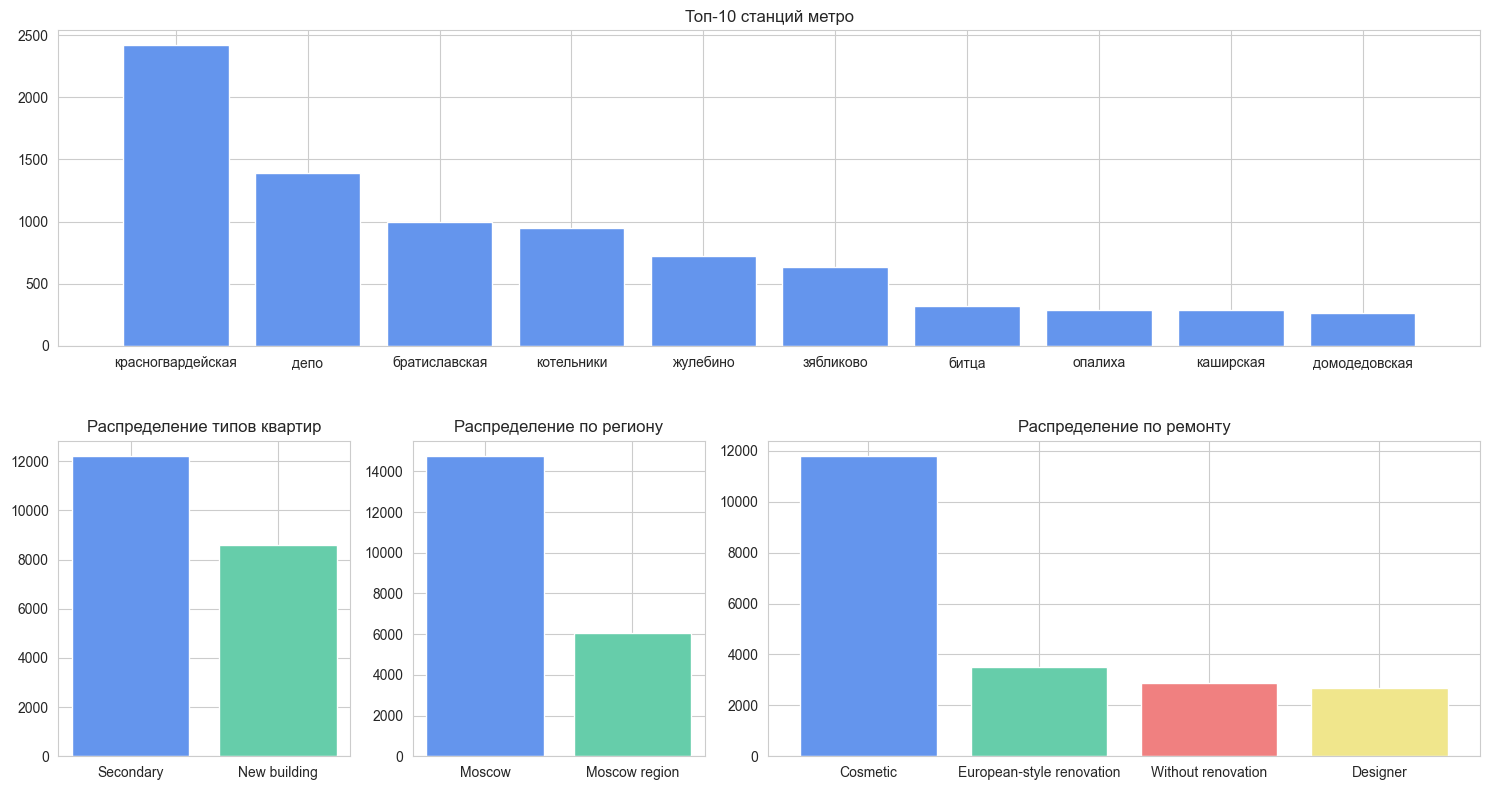

In [94]:
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(2, 3, width_ratios=[9, 9, 22])

counts = df['metro_station'].value_counts().sort_values(ascending=False)
ax1 = fig.add_subplot(gs[0, :])
ax1.bar(counts.index[:10], counts.values[:10], color='cornflowerblue') 
ax1.set_title('Топ-10 станций метро')

counts = df['apartment_type'].value_counts()
ax2 = fig.add_subplot(gs[1, 0])
ax2.bar(counts.index, counts.values, color=['cornflowerblue', 'mediumaquamarine'])
ax2.set_title('Распределение типов квартир')


counts = df['region'].value_counts()
ax3 = fig.add_subplot(gs[1, 1])
ax3.bar(counts.index, counts.values, color=['cornflowerblue', 'mediumaquamarine'])
ax3.set_title('Распределение по региону')

counts = df['renovation'].value_counts()
ax4 = fig.add_subplot(gs[1, 2])
ax4.bar(counts.index, counts.values, color=['cornflowerblue', 'mediumaquamarine', 'lightcoral', 'khaki'])
ax4.set_title('Распределение по ремонту')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

- `apartment_type`: большинство объектов — вторичное жильё **58,7%**. Новостройки составляют **41,3%**, распределение достаточно сбалансированное, что позволяет корректно учитывать влияние типа квартиры на цену.  
- `metro_station`: наиболее популярные станции — Красногвардейская **11,6%**, Депо **6,7%**, Братиславская **4,8%**, Котельники **4,6%**, Жулебино **3,5%**. Остальные станции встречаются реже.
- `region`: большинство квартир находится в Москве **70,9%**, остальные — в Московской области **29,1%**, что отражает концентрацию рынка недвижимости в столице.  
- `renovation`: большинство квартир имеют косметический ремонт **56,6%**. Европейский стиль — **16,8%**, без ремонта — **13,7%**, дизайнерский — **12,9%**.


#### 4.4 Корреляции

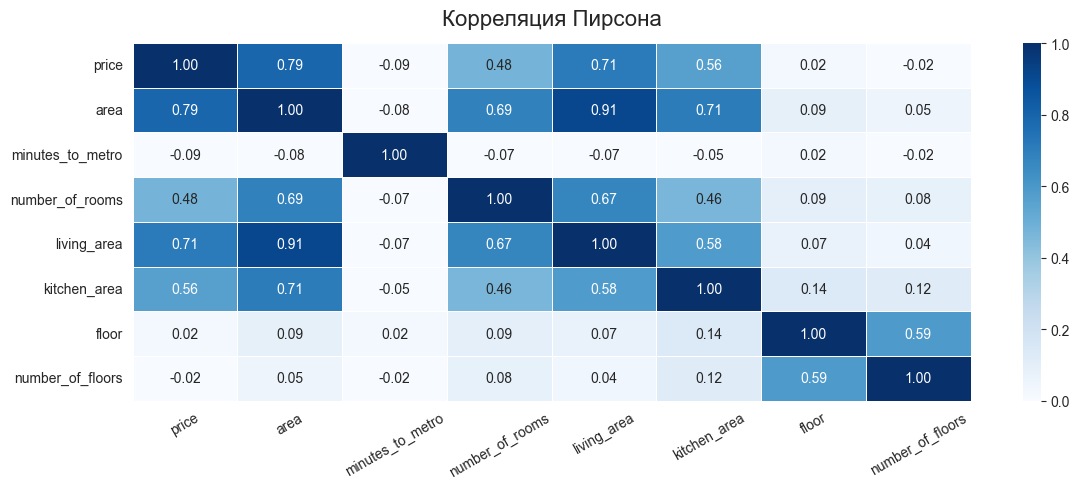

In [98]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(df[['price','area','minutes_to_metro','number_of_rooms',
            'living_area','kitchen_area','floor','number_of_floors']].corr(),
            annot=True, 
            fmt=".2f",
            linewidths=0.5,
            vmin=0, vmax=1,
            cmap='Blues');

ax.set_title('Корреляция Пирсона', fontsize=16, pad=13)
plt.xticks(rotation=30) 
plt.tight_layout()

In [100]:
 df[['price','area','minutes_to_metro','number_of_rooms',
     'living_area','kitchen_area','floor','number_of_floors']].corr()['price'].sort_values(ascending=False)

price               1.00
area                0.79
living_area         0.71
kitchen_area        0.56
number_of_rooms     0.48
floor               0.02
number_of_floors   -0.02
minutes_to_metro   -0.09
Name: price, dtype: float64

Анализ показывает, что на цену квартиры сильнее всего влияют `area`, `living_area`, `kitchen_area` и `number_of_rooms`.  
`floor` и `number_of_floors` практически не оказывают заметного влияния на цену. Также можно заметить слабую обратную зависимость от `minutes_to_metro`: квартиры, находящиеся дальше от станции, немного дешевле.

При этом `area` и `living_area` сильно коррелируют между собой - **0.91**, `area` и `kitchen_area` тоже имеют заметную связь - **0.71**, а `living_area` и `kitchen_area` **0.58**. Это логично, потому что все эти признаки в основном определяют размер квартиры, и показывает наличие мультиколлинеарности между основными признаками.  

Кроме того, корреляция Пирсона учитывает только числовые признаки и не позволяет оценить влияние категориальных переменных, а также данная корреляция учитывает только линейные зависимости и чувствительна к выбросам. Поэтому следующим шагом будет использование корреляции phik. В отличие от Пирсона, phik учитывает нелинейные зависимости и позволяет получить более полную картину факторов, влияющих на цену.

interval columns not set, guessing: ['price', 'minutes_to_metro', 'number_of_rooms', 'area', 'living_area', 'kitchen_area', 'floor', 'number_of_floors']


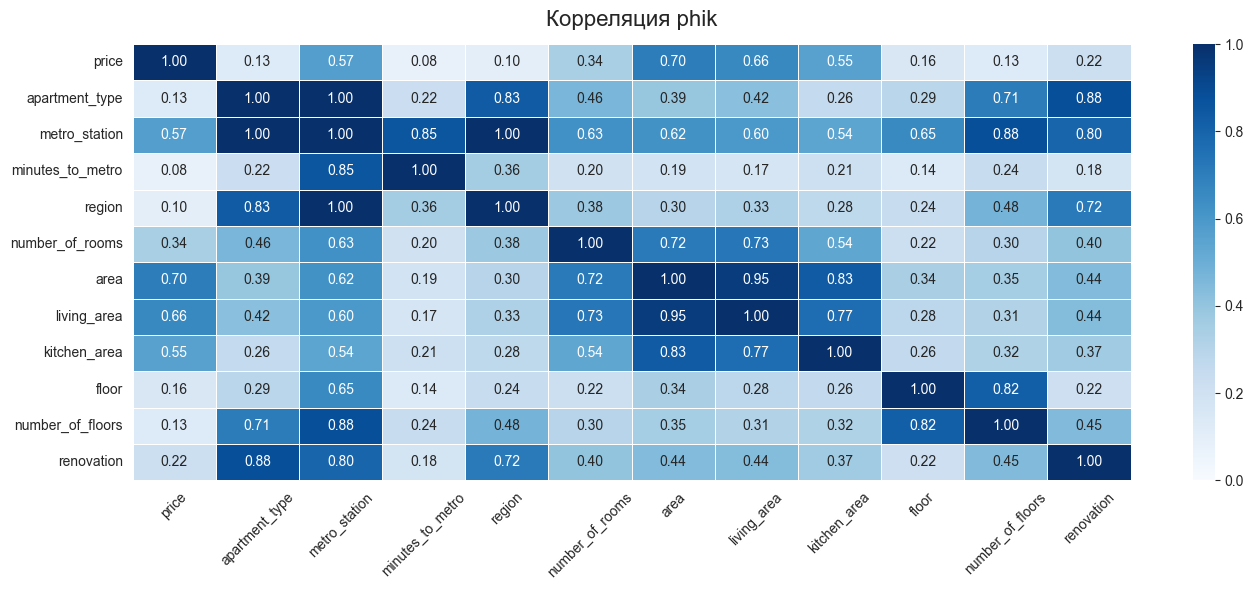

In [103]:
phik_overview = df.phik_matrix()
plt.figure(figsize=(14, 6))
sns.heatmap(phik_overview, 
            annot=True, 
            fmt=".2f", 
            cmap="Blues",
            vmin=0, vmax=1,
            linewidths=0.5)

plt.title("Корреляция phik", fontsize=16, pad=13)
plt.xticks(rotation=45)
plt.tight_layout()

In [105]:
phik_overview['price'].sort_values(ascending=False)

price              1.00
area               0.70
living_area        0.66
metro_station      0.57
kitchen_area       0.55
number_of_rooms    0.34
renovation         0.22
floor              0.16
apartment_type     0.13
number_of_floors   0.13
region             0.10
minutes_to_metro   0.08
Name: price, dtype: float64

Анализ матрицы phik показывает, что, как и в корреляции Пирсона, на цену квартиры наибольшее влияние оказывают площади — `area`, `living_area` и `kitchen_area`. В отличие от корреляции Пирсона, здесь влияние `number_of_rooms` слабее, но всё ещё присутствует. При этом на цену также влияет `metro_station`, что говорит о том, что, вероятнее всего, квартиры в более престижных районах ценятся выше. 

Признаки, связанные с размерами квартиры, так же, очевидно, сильно зависимы друг от друга.

Среди категориальных признаков наблюдаются сильные взаимосвязи внутри группы, включающей `apartment_type`, `metro_station`, `region` и `renovation`. Вероятно, это отражает особенности распределения станций метро и типов жилья в Москве и Московской области (например, новостроек и станций метро может быть больше в Москве, чем в области). Таким образом, локация, тип жилья и состояние квартиры взаимно усиливают друг друга.

В целом, большие квартиры в определенных районах стоят дороже, а признаки, связанные с этажностью, регионом, типом жилья или ремонтом практически не оказывают влияния на цену.

Теперь рассмотрим, как именно основные признаки связаны с ценой.

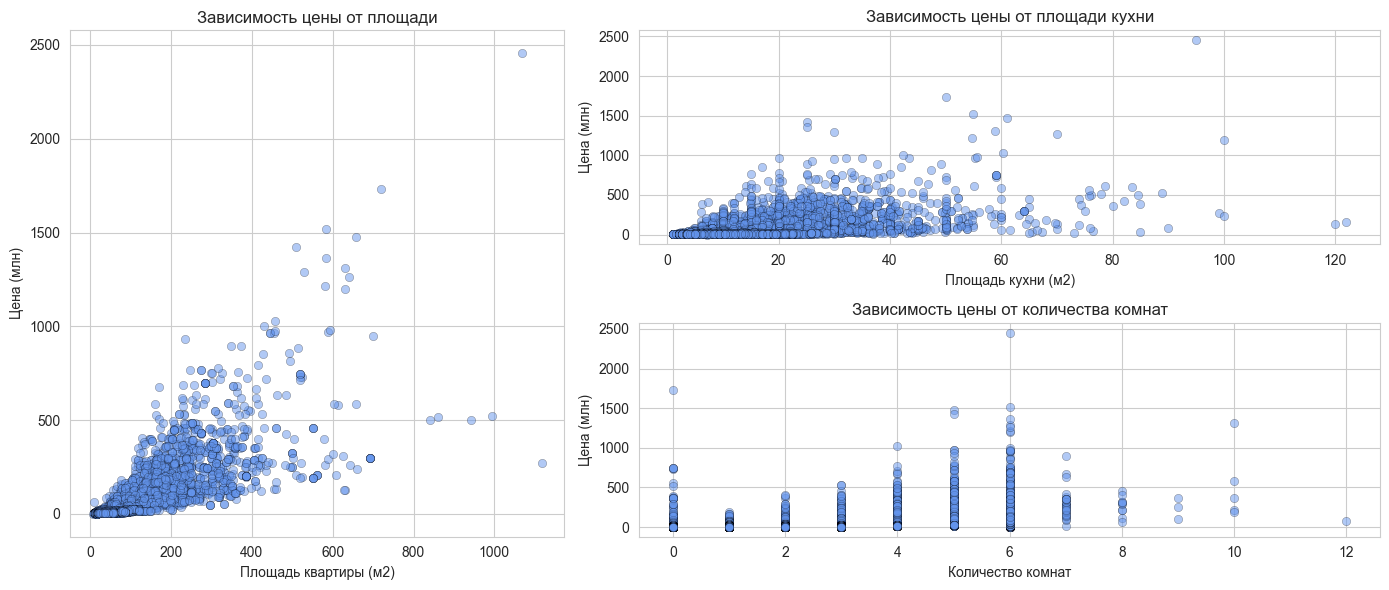

In [111]:
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[4,6]) 

ax1 = fig.add_subplot(gs[:, 0])
ax1.scatter(df['area'], df['price'] / 1e6, alpha=0.5, edgecolor='k', linewidth=0.3, color='cornflowerblue')
ax1.set_xlabel('Площадь квартиры (м2)')
ax1.set_ylabel('Цена (млн)')
ax1.set_title('Зависимость цены от площади');

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(df['kitchen_area'], df['price'] / 1e6, alpha=0.5, edgecolor='k', linewidth=0.3, color='cornflowerblue')
ax2.set_xlabel('Площадь кухни (м2)')
ax2.set_ylabel('Цена (млн)')
ax2.set_title('Зависимость цены от площади кухни');

ax3 = fig.add_subplot(gs[1, 1])
ax3.scatter(df['number_of_rooms'], df['price'] / 1e6, alpha=0.5, edgecolor='k', linewidth=0.3, color='cornflowerblue')
ax3.set_xlabel('Количество комнат')
ax3.set_ylabel('Цена (млн)')
ax3.set_title('Зависимость цены от количества комнат');

plt.tight_layout()

Анализ точечной диаграммы показывает, что существует явная положительная зависимость между `area` и `price`.  

Зависимость `price` от `kitchen_area` менее выражена, но также наблюдается положительная тенденция. 

Признак `number_of_rooms` показывает дискретную зависимость: цена растет при увеличении количества комнат, однако при этом сохраняется значительный разброс значений.

`living_area`, несмотря на высокую корреляцию с `price`, мы намеренно не используем при построении точечной диаграммы, так как, как мы уже выяснили, она сильно коррелирует с `area`, что создает мультиколлинеарность. Это может вызвать проблемы при построении модели, поэтому в будущем этот признак, возможно, следует удалить, чтобы избежать лишнего шума в данных.

#### 4.5 Сегментации

Для начала разобъем `area` и `kitchen_area` на бины и посмотрим, как цена зависит от размеров квартиры и кухни.

In [116]:
area_group = pd.cut(df['area'], [0, 50, 100, 150, 200, 250, 500, float('inf')])

In [118]:
df.groupby(area_group)['price'].agg(['count', 'mean', 'median'])

,count,mean,median
area,,,
"(0.0, 50.0]",9730,"8,905,317.09","7,500,000.00"
"(50.0, 100.0]",7939,"19,273,025.73","14,300,000.00"
"(100.0, 150.0]",1531,"72,815,595.91","58,813,000.00"
"(150.0, 200.0]",769,"140,564,163.31","125,000,000.00"
"(200.0, 250.0]",397,"204,862,796.19","165,422,750.00"
"(250.0, 500.0]",415,"317,922,949.86","278,677,179.00"
"(500.0, inf]",60,"614,679,108.80","460,000,000.00"


In [120]:
kitchen_area_group = pd.cut(df['kitchen_area'], [0, 10, 20, 30, 40, 70, float('inf')])

In [122]:
df.groupby(kitchen_area_group)['price'].agg(['count', 'mean', 'median'])

,count,mean,median
kitchen_area,,,
"(0.0, 10.0]",9146,"12,535,243.61","8,072,160.00"
"(10.0, 20.0]",9654,"30,394,106.06","12,444,860.50"
"(20.0, 30.0]",1469,"112,278,727.62","64,500,000.00"
"(30.0, 40.0]",340,"206,040,513.19","151,000,000.00"
"(40.0, 70.0]",206,"266,459,547.76","169,700,000.00"
"(70.0, inf]",26,"439,506,776.38","379,766,505.00"


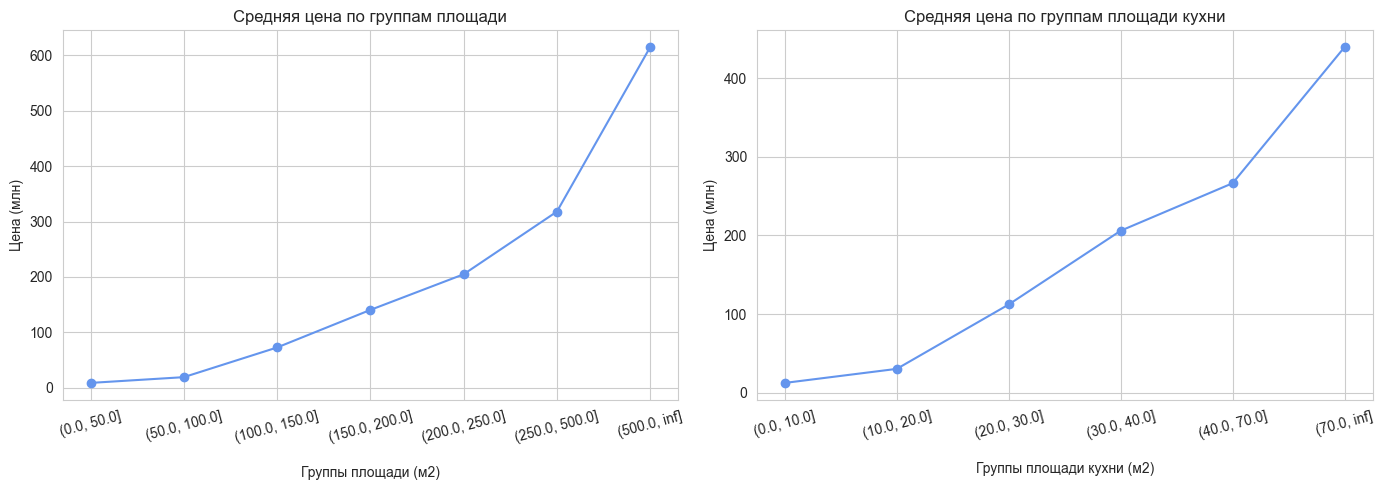

In [132]:
fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(1, 2) 

ax1 = fig.add_subplot(gs[0,0])
grouped = df.groupby(area_group)['price'].mean() / 1e6
ax1.plot(grouped.index.astype('str'), grouped, marker='o', color='cornflowerblue')
ax1.set_xlabel('Группы площади (м2)', labelpad=15)
ax1.set_ylabel('Цена (млн)')
ax1.set_title('Средняя цена по группам площади')
plt.xticks(rotation=15)

ax2 = fig.add_subplot(gs[0,1])
grouped = df.groupby(kitchen_area_group)['price'].mean() / 1e6
ax2.plot(grouped.index.astype('str'), grouped, marker='o', color='cornflowerblue');
ax2.set_xlabel('Группы площади кухни (м2)', labelpad=15)
ax2.set_ylabel('Цена (млн)')
ax2.set_title('Средняя цена по группам площади кухни')
plt.xticks(rotation=15)


plt.tight_layout()

Как видно из распределения по бинам, основная масса квартир по площади сосредоточена до **100 м2**. Средняя цена растёт пропорционально площади, причём особенно заметен резкий рост на больших квартирах, что связано с редкими дорогими объектами.

Основная масса кухонь — до **20 м2**. Средняя цена также увеличивается с ростом площади кухни.

Далее посмотрим, как цена распределяется по остальным признакам.

In [136]:
df.groupby('number_of_rooms')['price'].agg(['count','mean','median'])

,count,mean,median
number_of_rooms,,,
0,3236,"12,015,651.39","5,388,340.00"
1,4801,"10,931,651.78","8,644,470.00"
2,5996,"15,015,706.24","11,000,000.00"
3,3587,"31,977,439.14","18,558,825.00"
4,1801,"89,819,789.87","58,977,000.00"
5,851,"163,583,696.40","115,000,000.00"
6,523,"187,659,870.26","109,000,000.00"
7,27,"297,628,538.89","270,000,000.00"
8,10,"268,083,180.00","297,207,500.00"


In [138]:
df.groupby('apartment_type')['price'].agg(['count','mean','median'])

,count,mean,median
apartment_type,,,
New building,8614,"8,179,494.21","7,441,556.00"
Secondary,12227,"52,255,086.55","18,999,900.00"


In [140]:
df.groupby('renovation')['price'].agg(['count','mean','median'])

,count,mean,median
renovation,,,
Cosmetic,11806,"9,688,603.38","8,173,249.50"
Designer,2682,"110,831,986.32","65,000,000.00"
European-style renovation,3493,"33,399,088.96","19,700,000.00"
Without renovation,2860,"63,315,751.66","31,900,000.00"


In [142]:
df.groupby('region')['price'].agg(['count','mean','median'])

,count,mean,median
region,,,
Moscow,14773,"45,124,277.18","15,900,000.00"
Moscow region,6068,"7,046,829.20","6,580,620.00"


In [144]:
df.groupby('metro_station')['price'].agg(['count', 'mean','median'])  \
                                    .sort_values('mean', ascending=False).head(10)

,count,mean,median
metro_station,,,
площадь революции,5,"420,430,000.00","161,500,000.00"
лубянка,1,"325,980,125.00","325,980,125.00"
охотный ряд,30,"318,074,141.30","202,500,000.00"
театральная,3,"315,833,333.33","382,500,000.00"
боровицкая,8,"308,788,292.12","125,000,000.00"
парк культуры,80,"293,068,032.49","198,730,000.00"
библиотека им. ленина,4,"269,365,875.00","254,751,375.00"
лужники,30,"266,830,294.77","82,995,000.00"
фрунзенская,82,"263,742,217.61","250,000,000.00"


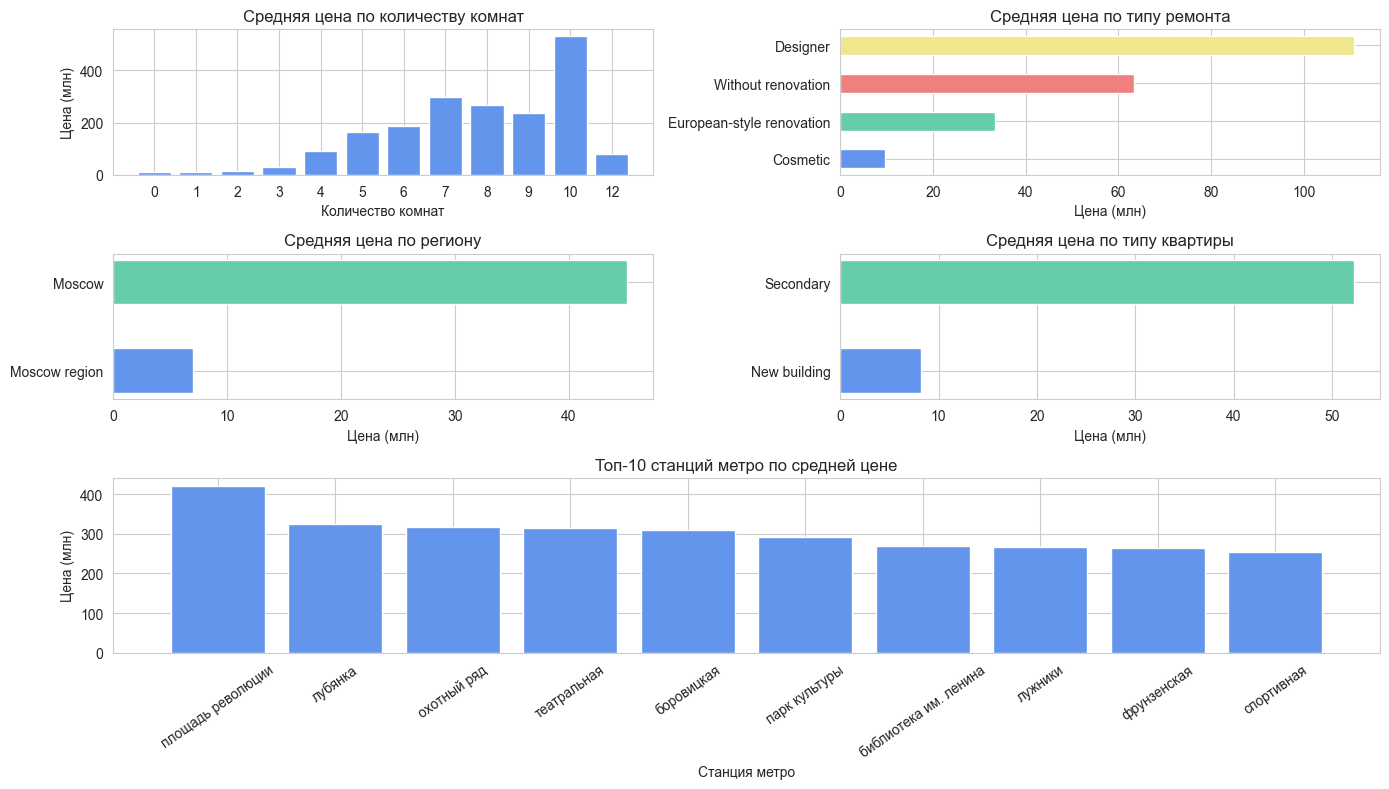

In [146]:
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1.2]) 

ax1 = fig.add_subplot(gs[0, 0])
grouped = df.groupby('number_of_rooms')['price'].mean() / 1e6
ax1.bar(grouped.index.astype(str), grouped.values, color='cornflowerblue')
ax1.set_xlabel('Количество комнат')
ax1.set_ylabel('Цена (млн)')
ax1.set_title('Средняя цена по количеству комнат')

ax2 = fig.add_subplot(gs[0,1])
grouped = (df.groupby('renovation')['price'].mean() / 1e6).sort_values()
ax2.barh(grouped.index, grouped.values, height=0.5, color=['cornflowerblue', 'mediumaquamarine', 'lightcoral', 'khaki'])
ax2.set_xlabel('Цена (млн)')
ax2.set_title('Средняя цена по типу ремонта')

ax3 = fig.add_subplot(gs[1,0])
grouped = (df.groupby('region')['price'].mean() / 1e6).sort_values()
ax3.barh(grouped.index, grouped.values, height=0.5, color=['cornflowerblue', 'mediumaquamarine'])
ax3.set_xlabel('Цена (млн)')
ax3.set_title('Средняя цена по региону')


ax4 = fig.add_subplot(gs[1,1])
grouped = df.groupby('apartment_type')['price'].mean() / 1e6
ax4.barh(grouped.index, grouped.values, height=0.5, color=['cornflowerblue', 'mediumaquamarine'])
ax4.set_xlabel('Цена (млн)')
ax4.set_title('Средняя цена по типу квартиры')

ax5 = fig.add_subplot(gs[2,:])
grouped = df.groupby('metro_station')['price'].mean().reset_index()
top10 = grouped.sort_values('price', ascending=False).head(10)
ax5.bar(top10['metro_station'], top10['price']/1e6, color='cornflowerblue')
ax5.set_xlabel('Станция метро')
ax5.set_ylabel('Цена (млн)')
ax5.set_title('Топ-10 станций метро по средней цене')
plt.xticks(rotation=35)


plt.tight_layout()

- `number_of_rooms`: основная часть предложений приходится на квартиры с 0–3 комнатами со средней ценой от **11 млн** до **32 млн**. Квартиры с 4–6 комнатами встречаются реже, а их средняя цена значительно выше — от **90 млн** до **188 млн**. Редкие 7–10-комнатные квартиры представлены единично и отличаются очень высокой стоимостью (от **236 млн** до **530 млн**).  

- `renovation`: тип ремонта существенно влияет на цену. Наиболее дорогие квартиры имеют дизайнерский ремонт со средней ценой **110 млн**. Так же высоко ценятся квартиры без ремонта (**63 млн**). Евроремонт имеет среднюю цену **33 млн**. Наиболее часто встречаются квартиры с косметическим ремонтом, но при этом они самые дешевые (**9,7 млн**).

- `region`: Москва формирует основной сегмент рынка, квартиры здесь заметно дороже (**45 млн**), чем в Московской области (**7 млн**).

- `apartment_type`: вторичное жильё (**52 млн**) значительно дороже новостроек (**8 млн**), что говорит о высоком спросе на готовые квартиры. 

- `metro_station`: cамые дорогие квартиры сосредоточены около станций, распологающихся непосредственно в центре столицы. 

#### 4.6 Анализ выбросов

Для начала рассмотрим квартиры с самыми высокими ценами (топ-1% выборки).

In [151]:
extreme_price = df[df['price'] > df['price'].quantile(0.99)]
extreme_price[['price','area','number_of_rooms','metro_station', 'renovation']].sort_values('price', ascending=False).head(10)

,price,area,number_of_rooms,metro_station,renovation
4090,2455020000,"1,067.40",6,маяковская,Designer
12840,1732170825,719.00,0,охотный ряд,Without renovation
9804,1517997000,584.10,6,парк культуры,Designer
3897,1475430000,657.50,5,площадь революции,Designer
9677,1422120000,508.00,5,боровицкая,Without renovation
11380,1362011000,584.10,6,парк культуры,Designer
11171,1313367750,630.00,10,баррикадная,Designer
10088,1289324394,529.80,6,лужники,Designer
11414,1264997500,640.00,6,баррикадная,Without renovation
4156,1214255500,581.00,6,кропоткинская,Designer


Как видно, это квартиры с очень большой площадью, расположенные в центре Москвы, с дизайнерским ремонтом или без ремонта. Эти объекты представляют собой сегмент элитного жилья, и их присутствие в данных оправдано.  
Далее рассмотрим квартиры с наибольшей площадью (также топ-1%).

In [154]:
extreme_area = df[df['area'] > df['area'].quantile(0.99)]
extreme_area[['price','area','number_of_rooms','metro_station','renovation']].sort_values('area', ascending=False).head(10)

,price,area,number_of_rooms,metro_station,renovation
1385,270000000,"1,117.00",0,новокузнецкая,Without renovation
4090,2455020000,"1,067.40",6,маяковская,Designer
1417,520000000,993.60,0,международная,Without renovation
2709,500000000,941.70,6,выставочная,Designer
910,516900000,861.50,6,народное ополчение,Designer
898,500000000,840.00,6,октябрьское поле,Without renovation
12840,1732170825,719.00,0,охотный ряд,Without renovation
10177,950000000,700.00,6,парк культуры,Designer
934,300000000,693.00,6,давыдково,Without renovation
10498,300000000,693.00,6,минская,Designer


Здесь также встречаются очень дорогие квартиры в центре или недалеко от него. Некоторые из них имеют **0 комнат**, однако это объясняется отсутствием ремонта и, скорее всего, открытой планировкой. Таким образом, это реальные объекты, а не ошибки.  
Теперь проанализируем квартиры с самыми большими кухнями (топ-1%).

In [157]:
extreme_kitchen = df[df['kitchen_area'] > df['kitchen_area'].quantile(0.99)]
extreme_kitchen[['price','kitchen_area','area', 'number_of_rooms', 'renovation']].sort_values('kitchen_area', ascending=False).head(10)

,price,kitchen_area,area,number_of_rooms,renovation
10977,159300000,122.00,267.00,4,Designer
10746,129000000,120.00,628.00,6,Designer
933,1200000000,100.00,630.00,6,Without renovation
3749,230000000,100.00,296.00,4,Designer
1385,270000000,99.10,"1,117.00",0,Without renovation
4090,2455020000,95.00,"1,067.40",6,Designer
11048,86999900,90.00,214.60,4,Designer
1417,520000000,88.80,993.60,0,Without renovation
12590,27840000,85.00,92.80,0,Without renovation
12295,380000000,85.00,304.00,0,Without renovation


В большинстве случаев большая кухня соответствует большой общей площади. Однако встречаются странности — например, квартира (**12590**), где кухня занимает почти всю площадь (**85 м2** из **92 м2**).

Чтобы проверить такие случаи, посмотрим квартиры, у которых кухня больше 80% площади:

In [161]:
df.loc[df['kitchen_area'] > 0.8 * df['area'], ['area','kitchen_area', 'number_of_rooms', 'renovation']]

,area,kitchen_area,number_of_rooms,renovation
5357,30.00,25.00,1,Cosmetic
11616,9.20,7.40,0,Cosmetic
11617,9.00,7.40,0,Cosmetic
12006,9.00,7.40,0,Cosmetic
12046,9.00,7.40,0,Cosmetic
12099,9.00,7.40,0,Cosmetic
12200,8.50,7.30,0,Cosmetic
12240,8.40,7.30,0,Cosmetic
12305,31.50,26.00,0,European-style renovation
12590,92.80,85.00,0,Without renovation


Подобных квартир немного. Чаще всего это студии или малогабаритные квартиры с кухней-гостиной. Встречаются и очень маленькие объекты (**6–10 м2**), где доля кухни в площади некорректна, но их количество незначительно. При этом присутсвует квартира (**13027**), у которой общая площадь меньше площади кухни. Проверим, много ли таких квартир, чтобы решить, что делать с ними дальше.

In [223]:
df[df['area'] < (df['kitchen_area'])]

,price,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
13027,1150000,Secondary,покровское,32,Moscow,0,6.00,5.20,7.10,2,18,Without renovation


Так как подобная аномалия встречается всего один раз, поэтому исключать или корректировать её мы не будем. Вероятнее всего, это ошибка заполнения площади, которая не оказывает значимого влияния на анализ и модель.

Экстремальные значения в данных в целом отражают реальные рыночные ситуации:

- элитные квартиры с огромной ценой и площадью

- студии и квартиры с открытой планировкой

- объекты с большой или нетепичной площадью кухни

Такие наблюдения встречаются редко и не оказывают значимого влияния на общую картину.

### Вывод по EDA:  

Данные показывают, что ключевыми факторами, определяющими цену на жилье являются ее **площадь** и **расположение**.  
Большие квартиры и объекты в центре с дизайнерским ремонтом стоят существенно дороже.   
Этажность и время до метро почти не влияют на цену.
Основная масса рынка — квартиры до **100 м2** с **косметическим** ремонтом и средней ценой до **15–20 млн**.

Выбросы в данных в основном отражают реальные особенности: элитные квартиры, студии с нестандартной планировкой или квартиры с большой кухней. Редкие аномалии по площади кухни или нулевому количеству комнат встречаются, но не искажают общую картину.

Также видно, что цена растёт с увеличением площади и числа комнат, а престижные районы формируют сегмент наиболее дорогих объектов. В целом данные корректны, отражают реальные рыночные ситуации и позволяют делать надёжные выводы о закономерностях образования цены на рынке недвижимости.

## 5. Статистический анализ и проверка гипотез

На этапе EDA мы заметили, что распределения числовых признаков сильно отличаются от нормального и содержат выбросы.  
Для проверки устойчивости результатов корреляционного анализа будем сравнивать коэффициенты Пирсона, Спирмена и Кендалла по отношению к цене.  

**H0**: цена не зависит от площади (`area`, `living_area`, `kitchen_area`, `number_of_rooms`).  

**H1**: площадь оказывает влияние на цену.

In [230]:
columns_num = ['area', 'living_area', 'kitchen_area', 'number_of_rooms']

for col in columns_num:
    r_p, p_p = pearsonr(df['price'], df[col])
    r_s, p_s = spearmanr(df['price'], df[col])
    r_k, p_k = kendalltau(df['price'], df[col])
    
    print(f'Price - {col}:')
    print(f'Pearson {r_p:.2f}, p-value {p_p:.3f}')
    print(f'Spearman {r_s:.2f}, p-value {p_s:.3f}')
    print(f'Kendall {r_k:.2f}, p-value {p_k:.3f}\n')

Price - area:
Pearson 0.79, p-value 0.000
Spearman 0.79, p-value 0.000
Kendall 0.61, p-value 0.000

Price - living_area:
Pearson 0.71, p-value 0.000
Spearman 0.72, p-value 0.000
Kendall 0.54, p-value 0.000

Price - kitchen_area:
Pearson 0.56, p-value 0.000
Spearman 0.55, p-value 0.000
Kendall 0.39, p-value 0.000

Price - number_of_rooms:
Pearson 0.48, p-value 0.000
Spearman 0.66, p-value 0.000
Kendall 0.53, p-value 0.000



Как можно заметить, для всех признаков p-value практически равен 0. Следовательно, связь площади с ценой статистически значима.  
Наибольшая связь наблюдается у `area` и `living_area`. Нулевая гипотеза отвергается, то есть площадь оказывает существенное влияние на цену.

Проверим, различаются ли цены квартир в Москве и Московской области.
Так как распределение цен заметно скошено и содержит выбросы, применим критерий Манна–Уитни, который не требует нормальности распределения и устойчив к выбросам.

**H0**: регион не оказывает влияния на цену.

**H1**: цена зависит от региона.

In [247]:
moscow = df[df['region'] == 'Moscow']['price']
moscow_region = df[df['region'] == 'Moscow region']['price']

stat, p_value = mannwhitneyu(moscow, moscow_region)
print(f'p-value = {p_value:.3f}')

p-value = 0.000


Цены в Москве и области статистически значимо различаются, нулевая гипотеза отвергается.

Так же проверим, различается ли средняя цена на вторичку и новостройки.

**H0**: тип жилья не оказывает влияния на цену.

**H1**: цена зависит от типа жилья.

In [252]:
secondary = df[df['apartment_type'] == 'Secondary']['price']
new_building = df[df['apartment_type'] == 'New building']['price']

stat, p_value = mannwhitneyu(secondary, new_building)
print(f'p-value = {p_value:.3f}')

p-value = 0.000


Распределения цен для новостроек и вторичного жилья статистически значимо различаются. Нулевая гипотеза отвергается, следовательно, тип жилья оказывает влияние на цену.

На основе проведённого статистического анализа установлено, что площадь квартиры, тип жилья и регион оказывают статистически значимое влияние на цену. Наибольшая связь наблюдается у общей и жилой площади. Средняя цена различается между новостройками и вторичкой, а также между Москвой и Московской областью. Эти признаки следует учитывать при построении модели предсказания стоимости недвижимости.

## 6. Построение моделей машинного обучения  
   6.1 Подготовка данных  
   6.2 kNN   
   6.3 CatBoost

#### 6.1 Подготовка данных
Для начала разделим данные на train и test.

In [258]:
X = df[['apartment_type','metro_station','minutes_to_metro','region',
        'number_of_rooms','area','living_area','kitchen_area',
        'floor','number_of_floors','renovation']]
y = df['price']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

В наших данных, как было уже замечено выше, присутствуют **существенные выбросы**. Это редкие объекты с экстремально высокой ценой. Их наличие способно существенно исказить результаты моделей, так как они не отражают поведение **типичного объекта рынка**.

Метод **kNN** особенно чувствителен к выбросам: при поиске ближайших соседей даже одна аномальная квартира может повлиять на прогноз других объектов. Однако и алгоритмы градиентного бустинга, такие как **CatBoost**, также могут уделять чрезмерное внимание выбросам, увеличивая общую ошибку и ухудшая обобщающую способность модели.

Поскольку целью проекта является построение модели, предсказывающей цену именно **типичных квартир**, мы исключаем влияние экстремальных объектов. Для этого применим метод *интерквартильного размаха* (IQR):

1. Определим границы выбросов только на обучающей части данных, чтобы исключить утечку информации о тестовой выборке.

2. Эти границы затем применим как к обучающей, так и к тестовой выборке, чтобы сравнение моделей происходило на данных из одного распределения.

Таким образом, это позволит нам сделат модели наиболее устойчивыми и стабильными в вопросе предсказания цен типичных квартир.

In [262]:
Q1 = ytrain.quantile(0.25)
Q3 = ytrain.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

train_mask = (ytrain >= lower) & (ytrain <= upper) 
Xtrain_f = Xtrain.loc[train_mask].copy() 
ytrain_f = ytrain.loc[train_mask].copy()
print(f'Удалено выбросов из train: {len(Xtrain) - len(Xtrain_f)} из {len(Xtrain)}')

test_mask = (ytest >= lower) & (ytest <= upper)
Xtest_f = Xtest.loc[test_mask]
ytest_f = ytest.loc[test_mask]
print(f'Удалено выбросов из test: {len(Xtest) - len(Xtest_f)} из {len(Xtest)}')

Удалено выбросов из train: 2409 из 16672
Удалено выбросов из test: 611 из 4169


#### 6.2 kNN

В качестве первой модели используем **kNN**. Она выбрана как базовая, так как просто и наглядно реализует идею: похожие квартиры должны стоить примерно одинаково. Перед обучением необходимо закодировать категориальные признаки, нормализовать данные и подобрать гиперпараметры по сетке.  

Для кодирования категориальных переменных будем использовать **Target Encoding**, так как простое **One-hot кодирование** создаст слишком много признаков и лишнего шума из-за большого количества станций метро. Target Encoding позволяет компактно преобразовать такие признаки, учитывая связь категории с целевой переменной.  
Для числовых признаков применим **StandardScaler**, чтобы все признаки были в одной шкале. Это важно для kNN: без нормализации крупные значения будут доминировать над мелкими.  
Чтобы избежать утечек при кросс-валидации, построим **Pipeline**, включающий Target Encoding, StandardScaler и модель, что позволит корректно подбирать гиперпараметры.

In [267]:
pipeline = Pipeline(steps=[
    ('encoder', ce.TargetEncoder(cols=['metro_station', 'region', 'apartment_type', 'renovation'])),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

Далее подберем оптимальные гиперпараметры для обучения модели.  
В случае **kNN** необходимо:
- выбрать количество ближайших соседей: малое значение ведёт к переобучению, слишком большое — к недообучению
- определить способ задания весов: либо все соседи равны, либо более близкие имеют больший вес
- подобрать подходящую метрику расстояния: именно она определяет, как измеряется «похожесть» объектов

In [272]:
param_grid = {
    'knn__n_neighbors': range(1, 21, 2),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

grid_search.fit(Xtrain_f, ytrain_f)

print('Лучшие параметры:', grid_search.best_params_)
print('Лучший R2 на кросс-валидации:', grid_search.best_score_)

Лучшие параметры: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Лучший R2 на кросс-валидации: 0.8906758370231044


Теперь, когда мы подобрали оптимальные параметры, построим финальную модель и сделаем предсказания:

In [274]:
best_model = grid_search.best_estimator_
ytrain_pred = best_model.predict(Xtrain_f)
ytest_pred = best_model.predict(Xtest_f)

print(f'R2 на трейне: {r2_score(ytrain_f, ytrain_pred):.3f}')
print(f'R2 на тесте: {r2_score(ytest_f, ytest_pred):.3f}')
print(f"MAE: {mean_absolute_error(ytest_f, ytest_pred):,.0f}")
print(f"RMSE: {root_mean_squared_error(ytest_f, ytest_pred):,.0f}")
print(f"MAPE: {mean_absolute_percentage_error(ytest_f, ytest_pred) * 100:.2f}%")

R2 на трейне: 1.000
R2 на тесте: 0.896
MAE: 1,554,569
RMSE: 2,918,445
MAPE: 10.47%


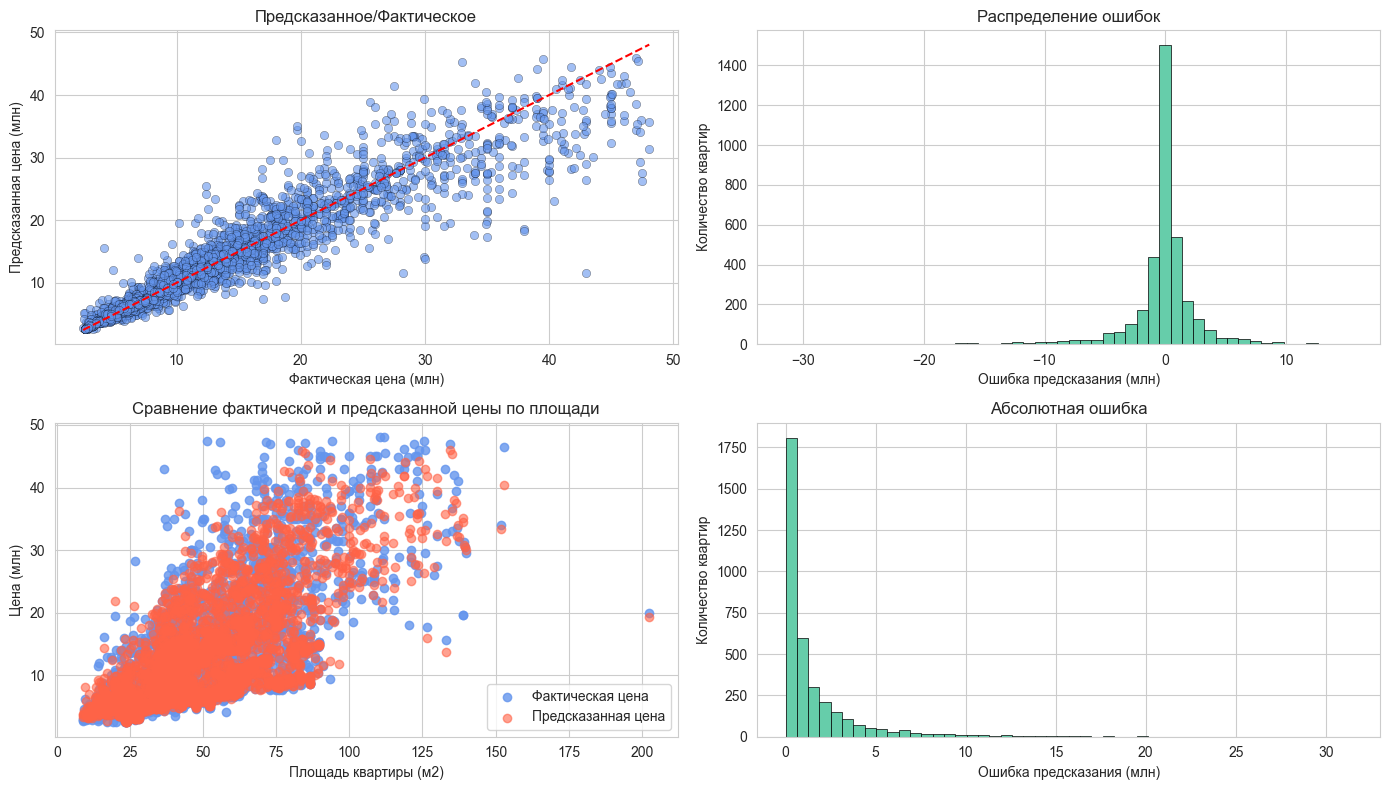

In [119]:
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2)


ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(ytest_f / 1e6, ytest_pred / 1e6, alpha=0.6, edgecolor='k', linewidth=0.3, color='cornflowerblue')
ax1.plot([(ytest_f / 1e6).min(), (ytest_f / 1e6).max()], [(ytest_f / 1e6).min(), (ytest_f / 1e6).max()], 'r--')
ax1.set_xlabel('Фактическая цена (млн)')
ax1.set_ylabel('Предсказанная цена (млн)')
ax1.set_title('Предсказанное/Фактическое')


ax2 = fig.add_subplot(gs[0, 1])
ax2.hist((ytest_pred - ytest_f) / 1e6, bins=50, color='mediumaquamarine', edgecolor='k', linewidth=0.5)
ax2.set_xlabel('Ошибка предсказания (млн)')
ax2.set_ylabel('Количество квартир')
ax2.set_title('Распределение ошибок')

ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(df.loc[ytest_f.index, 'area'], ytest_f / 1e6, color='cornflowerblue', alpha=0.8, label='Фактическая цена')
ax3.scatter(df.loc[ytest_f.index, 'area'], ytest_pred / 1e6, color='tomato', alpha=0.6, label='Предсказанная цена')
ax3.set_xlabel('Площадь квартиры (м2)')
ax3.set_ylabel('Цена (млн)')
ax3.set_title('Сравнение фактической и предсказанной цены по площади')
ax3.legend()

ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(np.abs(ytest_pred - ytest_f) / 1e6, bins=50, color='mediumaquamarine', edgecolor='k', linewidth=0.5)
ax4.set_xlabel('Ошибка предсказания (млн)')
ax4.set_ylabel('Количество квартир')
ax4.set_title('Абсолютная ошибка')

plt.tight_layout()

#### Выводы по kNN:

Модель показала хороший результат. Благодаря удалению выбросов удалось снизить влияние экстремально дорогих квартир. При этом дорогие квартиры все равно сохранились в наших данных в пределах разумного: как было видно в EDA, основная масса сосредоточена до 20 млн, а после фильтрации остались квартиры примерно до 50 млн.
Удаление выбросов было оправданно: даже одна очень дорогая квартира могла бы исказить результат для ближайших соседей. Так как цель проекта — предсказание цены в **среднем для рынка**, решение удалить выбросы оказалось правильным и дало хороший эффект.

R2 на трейне оказался равным **1.000**, но это не классическое переобучение. Дело в параметре *weights='distance'*: на обучении каждая точка является сама себе ближайшим соседом, и scikit-learn по умолчанию даёт ей вес 1, а остальные соседи не учитываются. На тесте же точки новые, и там мы получили R2 = **0.896**, что отражает высокое качество модели.  

- MAE = **1.5 млн**, что говорит о средней ошибке между предсказанием и реальностью.  
- RMSE = **2.9 млн** показывает, что крупные ошибки встречаются, но критично не выбиваются.  
- MAPE = **10.5%**, в среднем модель ошибается примерно на 10% от реальной цены, что можно считать вполне приемлемым для модели такого уровня.

Графики показывают, что модель уверенно работает на типичных квартирах со средней ценой, а с ростом цены качество падает. Это ещё раз подтверждает, что удаление выбросов было правильным решением: иначе ошибки на дорогих объектах тянули бы вниз всю модель.  
Распределение ошибок выглядит близким к нормальному: есть левый хвост — дорогие квартиры модель склонна немного занижать, так как она опирается на большинство квартир в среднем сегменте.  
По графику цены по площади видно, что на стандартных площадях модель справляется хорошо, а на больших площадях и ценах разброс становится больше, что логично из-за меньшего количества таких объектов.

В целом, kNN показал высокую предсказательную способность, несмотря на простоту, и служит отличной базовой моделью. Но у метода есть свои слабые стороны: *чувствительность к выбросам* и *слабая работа с редкими случаями*. Поэтому следующим шагом будет использование более гибкой модели — CatBoost, который способен уловить сложные нелинейные зависимости и лучше работать с категориальными признаками.

#### 6.3 CatBoost

Для решения задачи прогнозирования стоимости квартиры была выбрана модель градиентного бустинга CatBoost. Такой выбор обусловлен её способностью выявлять сложные нелинейные зависимости, устойчивостью к шуму и удобной работой с категориальными признаками без дополнительного кодирования.

Обубчающую выборку необходимо дополнительно разделить на тренировочную и валидационную подвыборки. Это необходимо для того, чтобы подобрать оптимальное число итераций и предотвращения переобучения:

In [280]:
Xtrain_in, Xval, ytrain_in, yval = train_test_split(Xtrain_f, ytrain_f, test_size=0.2, random_state=42)

Категориальные признаки необходимо передать модели напрямую, а Catboost самостоятельно их закодирует:

In [283]:
cat_features = ['apartment_type', 'metro_station', 'region', 'renovation']

Далее на тренировочной и валидационной выборках подберем оптмальные параметры и количество итераций. Будем останавливать обучение в тот момент, когда качество на валидации перестанет улучшаться.

In [286]:
model_temp = CatBoostRegressor(
    cat_features=cat_features,
    iterations=3000,
    learning_rate=0.07,
    depth=8,
    random_seed=42,
    early_stopping_rounds=200,
    verbose=200
)

model_temp.fit(Xtrain_in, ytrain_in, eval_set=(Xval, yval), use_best_model=True)
best_it = model_temp.get_best_iteration()

0:	learn: 8640809.0498087	test: 8529483.6110189	best: 8529483.6110189 (0)	total: 213ms	remaining: 10m 38s
200:	learn: 2603885.5704506	test: 3038869.2931940	best: 3038869.2931940 (200)	total: 14.3s	remaining: 3m 19s
400:	learn: 2173718.8155609	test: 2902102.4818807	best: 2901862.4132532 (399)	total: 28.5s	remaining: 3m 4s
600:	learn: 1857147.5281348	test: 2836766.2678196	best: 2835263.0737250 (575)	total: 42.5s	remaining: 2m 49s
800:	learn: 1641758.6417597	test: 2808550.3241689	best: 2808550.3241689 (800)	total: 56.6s	remaining: 2m 35s
1000:	learn: 1476505.8036197	test: 2786324.0644461	best: 2786198.6133814 (986)	total: 1m 11s	remaining: 2m 22s
1200:	learn: 1361509.9210353	test: 2774749.6144019	best: 2774660.0454916 (1198)	total: 1m 25s	remaining: 2m 8s
1400:	learn: 1242042.3295841	test: 2763781.9232923	best: 2763160.7151261 (1397)	total: 1m 40s	remaining: 1m 54s
1600:	learn: 1156670.6057364	test: 2758786.6837374	best: 2758567.2950457 (1599)	total: 1m 54s	remaining: 1m 40s
1800:	learn: 

На следующем этапе обучим модель на всей обучайщей выборке, подставив оптимальное число итераций:

In [289]:
model_cb = CatBoostRegressor(
    cat_features=cat_features,
    iterations=best_it + 1,
    learning_rate=0.07,
    depth=8,
    random_seed=42,
    verbose=200
)

model_cb.fit(Xtrain_f, ytrain_f)

y_pred_train = model_cb.predict(Xtrain_f)
y_pred_test  = model_cb.predict(Xtest_f)

print(f'R2 на трейне: {r2_score(ytrain_f, y_pred_train):.3f}')
print(f'R2 на тесте:  {r2_score(ytest_f, y_pred_test):.3f}')
print(f'MAE:  {mean_absolute_error(ytest_f, y_pred_test):,.0f}')
print(f'RMSE: {root_mean_squared_error(ytest_f, y_pred_test):,.0f}')
print(f'MAPE: {mean_absolute_percentage_error(ytest_f, y_pred_test)*100:.2f}%')

0:	learn: 8621432.8917871	total: 64.6ms	remaining: 2m 14s
200:	learn: 2651555.1124287	total: 15.3s	remaining: 2m 22s
400:	learn: 2234900.4416599	total: 29.9s	remaining: 2m 5s
600:	learn: 1966137.7501310	total: 44.8s	remaining: 1m 50s
800:	learn: 1745769.9877772	total: 59.6s	remaining: 1m 35s
1000:	learn: 1570181.3271764	total: 1m 14s	remaining: 1m 20s
1200:	learn: 1438821.0647480	total: 1m 29s	remaining: 1m 5s
1400:	learn: 1328632.2933730	total: 1m 45s	remaining: 51.3s
1600:	learn: 1230031.6056778	total: 1m 59s	remaining: 36s
1800:	learn: 1142194.3576787	total: 2m 13s	remaining: 21s
2000:	learn: 1070740.9133860	total: 2m 28s	remaining: 6.16s
2083:	learn: 1040550.1798892	total: 2m 34s	remaining: 0us
R2 на трейне: 0.972
R2 на тесте:  0.914
MAE:  1,424,926
RMSE: 2,648,198
MAPE: 9.90%


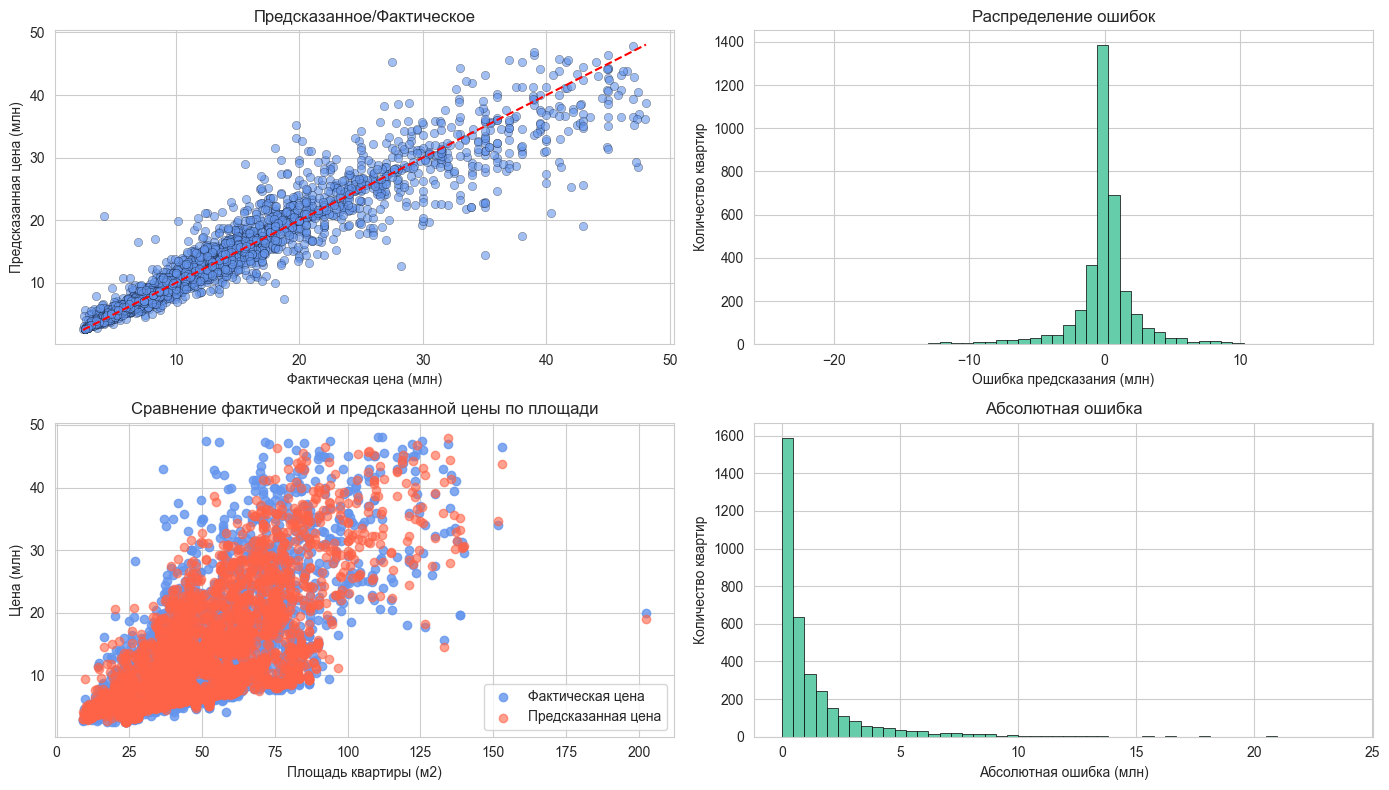

In [291]:
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(ytest_f / 1e6, y_pred_test / 1e6, alpha=0.6, edgecolor='k', linewidth=0.3, color='cornflowerblue')
ax1.plot([ytest_f.min()/1e6, ytest_f.max()/1e6], [ytest_f.min()/1e6, ytest_f.max()/1e6], 'r--')
ax1.set_xlabel('Фактическая цена (млн)')
ax1.set_ylabel('Предсказанная цена (млн)')
ax1.set_title('Предсказанное/Фактическое')

ax2 = fig.add_subplot(gs[0, 1])
ax2.hist((y_pred_test - ytest_f) / 1e6, bins=50, color='mediumaquamarine', edgecolor='k', linewidth=0.5)
ax2.set_xlabel('Ошибка предсказания (млн)')
ax2.set_ylabel('Количество квартир')
ax2.set_title('Распределение ошибок')

ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(df.loc[ytest_f.index, 'area'], ytest_f / 1e6, color='cornflowerblue', alpha=0.8, label='Фактическая цена')
ax3.scatter(df.loc[ytest_f.index, 'area'], y_pred_test / 1e6, color='tomato', alpha=0.6, label='Предсказанная цена')
ax3.set_xlabel('Площадь квартиры (м2)')
ax3.set_ylabel('Цена (млн)')
ax3.set_title('Сравнение фактической и предсказанной цены по площади')
ax3.legend()

ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(np.abs(y_pred_test - ytest_f) / 1e6, bins=50, color='mediumaquamarine', edgecolor='k', linewidth=0.5)
ax4.set_xlabel('Абсолютная ошибка (млн)')
ax4.set_ylabel('Количество квартир')
ax4.set_title('Абсолютная ошибка')

plt.tight_layout()

CatBoost показал лучший результат, чем kNN. Если у kNN на тесте R2 был **0.896**, то у CatBoost **0.914**, и при этом на трейне (**0.972**) видно, что сильного переобучения нет, модель не просто запомнила данные, а научилась обобщать.  

- **МАЕ** снизилась с **1.55 млн** до **1.42 млн**
- **RMSE** упал с **2.9 млн** до **2.65 млн** — значит, крупных ошибок стало меньше
- **MAPE** сократился с **10.47%** до **9.90%**, то есть в среднем модель ошибается меньше чем на 10% от реальной цены

На графиках также видно, что предсказанные значения близки к фактическим, ошибки распределены симметрично вокруг нуля, а связь цены с площадью отражена корректно — модель улавливает рост стоимости при увеличении площади. Гистограмма абсолютной ошибки подтверждает: основная масса квартир предсказывается с разбросом до нескольких миллионов рублей, экстремальные случаи встречаются реже.  

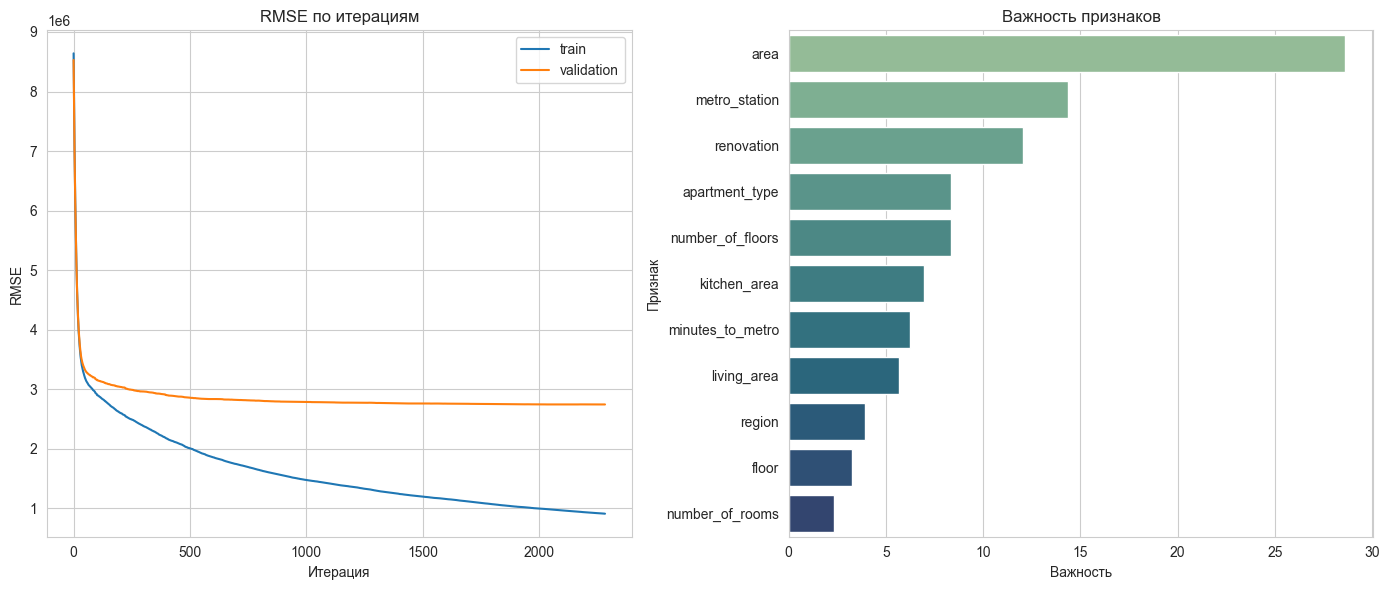

In [305]:
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
evals = model_temp.get_evals_result()
train_metric = evals['learn']['RMSE']
valid_metric = evals['validation']['RMSE']
ax1.plot(train_metric, label='train')
ax1.plot(valid_metric, label='validation')
ax1.set_title('RMSE по итерациям')
ax1.set_xlabel('Итерация')
ax1.set_ylabel('RMSE')
ax1.legend()

importances = model_cb.get_feature_importance(prettified=True)
ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(x='Importances', y='Feature Id', data=importances, palette='crest', ax=ax2)
ax2.set_title('Важность признаков')
ax2.set_xlabel('Важность')
ax2.set_ylabel('Признак')

plt.tight_layout()
plt.show()

На кривой обучения видно, что модель стабильно снижает ошибку на трейне, а на валидации постепенно выравнивается. Это значит, что нам удалось избежать переобучения: после определённого момента качество перестаёт расти, и модель останавливается на оптимальных итерациях.

Если смотреть на важность признаков, то, ожидаемо, на первом месте можно заметить общую площадь квартиры, то есть именно она оказывает наибольшее влияние на цену. На втором месте — станция метро, что подтверждает важность расположения квартиры. Дальше идут ремонт и тип жилья (новостройка или вторичка), а также количество этажей в доме и площадь кухни. Остальные признаки влияют, но заметно слабее.

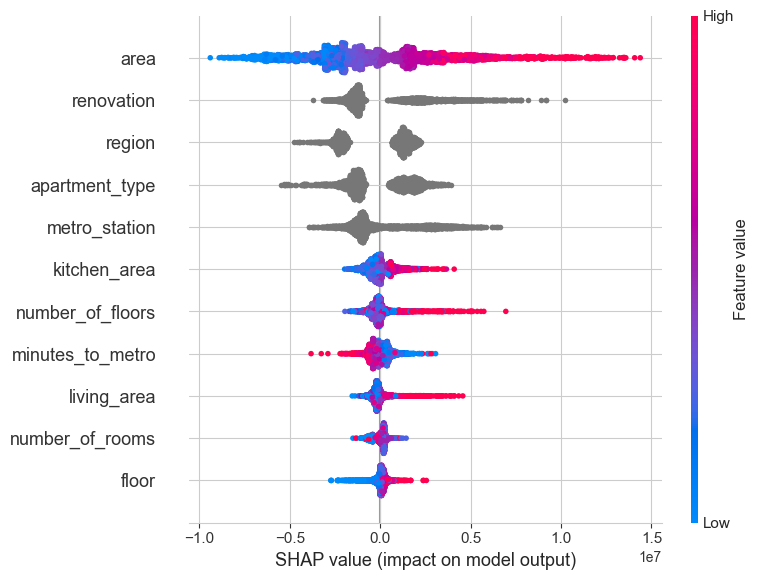

In [308]:
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(Xtest_f)
shap.summary_plot(shap_values, Xtest_f)

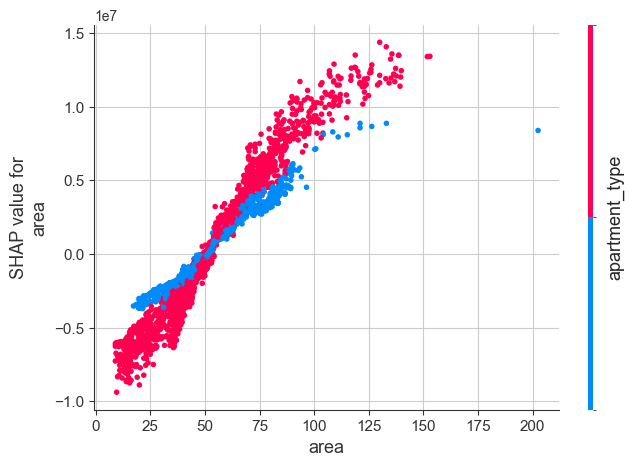

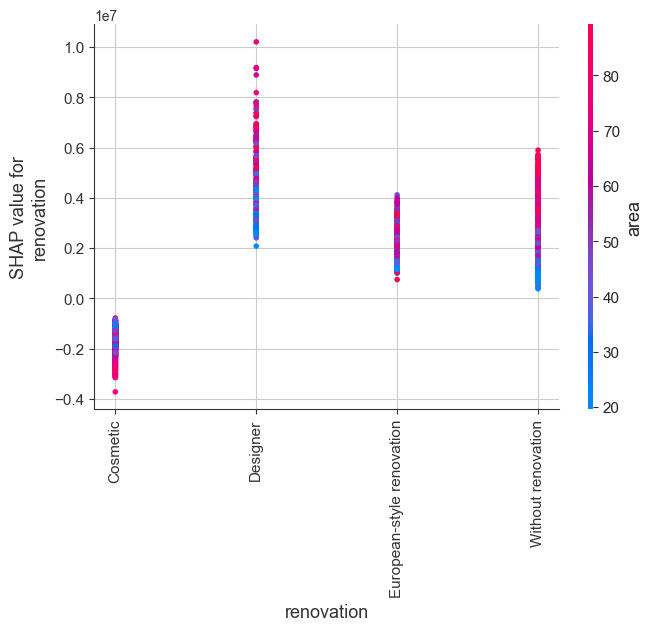

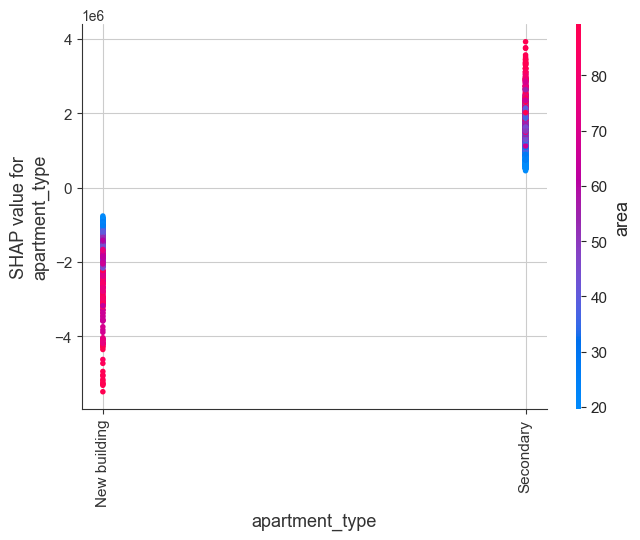

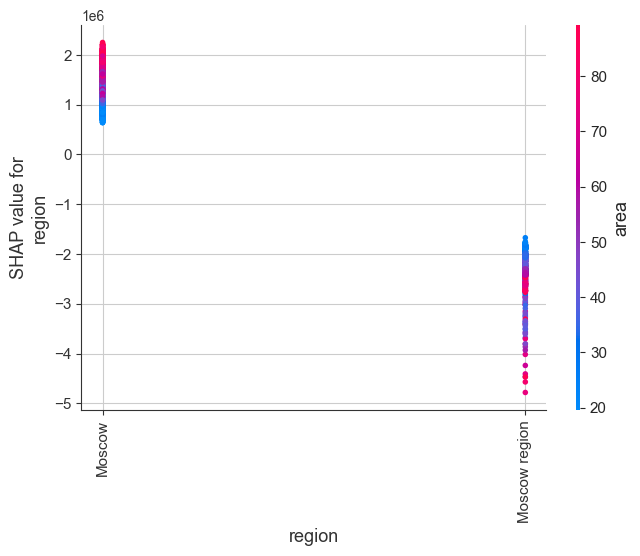

In [310]:
key_features = ['area', 'renovation', 'apartment_type', 'region']

for i in key_features:
    shap.dependence_plot(i, shap_values, Xtest_f)

CatBoost дает нам возможность посмотреть не только на качество предсказаний, но и на то, какие признаки оказывают наибольшее влияние на цену.  
SHAP показал, что главным фактором закономерно является площадь квартиры.

Сильное влияние оказывает и тип ремонта. Квартиры с дизайнерским ремонтом заметно повышают цену, а косметический ремонт почти не добавляет стоимости. Новостройка и вторичка так же сильно влияют на предсказание.

Квартиры в Московской области тянут показатель SHAP вниз, а в Москве их влияние на цену заметно выше. Отдельно хочется заметить, что расстояние до метро, показывает обратную зависимость. То есть, как следует из логики, чем меньше расстояние до метро, тем более важно для модели это было в вопросе предсказания цены.

В целом, модель подтвердила здравый смысл: цена определяется базовыми характеристиками жилья (площадь, тип квартиры, качество ремонта) и его расположением. Остальные факторы (этаж, количество комнат, расстояние до метро) влияют меньше, но всё равно учитываются.

## Выводы по проекту

#### Общие выводы
Анализ позволил подтвердить некоторые очевидные закономерности ценообразования на рынке недвижимости.  
**Местоположение** и **площадь** - решающие факторы, которые оказывают влияние на цену квартиры. Квартиры в Москве стоят существенно дороже, чем в подмосковье, а близость к центру и  определенным станциям метро также повышает цену.  
**Дизайнерский ремонт** заметно большее влияние оказывает на цену, а косметический ремонт почти не влияет. Неожиданно дорогими оказались квартиры без отделки, так как, вероятно, это квартиры со свободной планировкой, поэтому отстутсвие ремонота необязательно значит, что квартира принадлежит к бюджетному классу.  
**Этажность дома** и **этаж**, на котором распологается квартира, оказались менее значимы для цены: покупатели, судя по всему, готовы платить и за высокие этажи, и за низкие. При этом общее количество этажей показывают определенную значимость. Возможно, престижность дома и квартиры в нем определяется тем, насколько много у него этажей.  
**Удалённость от метро** тоже не показала сильной связи с ценой. Вероятно потому, что в Москве метро находится в шаговой доступности, а в области, возможно, наличие машины может снизить важность метро. Тем не менее, отсутствие поблизости метро может несколько снижать привлекательность и модель это учитывает.

#### Качество модели

Нам удалось разработать модель градиентого бустинга **Catboost**, которая способна достаточно точно прогнозировать цены на жилье. Средняя ошибка для нее составила примерно **1.4 млн**, что примерно **10%** от средней цены на тесте. Для рынка недвижимости это может служить относительно хорошим результатом. Модель способна объяснять около **91%** вариации цен, что свидетельствует о том, что она смогла учесть основные закономерности.  
Базовая модель **kNN**, которая была выбрана для сравнения, также показала хороший результат благодаря оптимально подобранным гиперпараметрам и лишь немного уступает модели градиентного бустинга. Таким образом, применение более сложного алгоритма оправдало себя, хотя и не столь замтено из-за качественно выстроенной модели kNN и относительно хорошего качества данных.  

Здесь также важно отметить, что такое качество было достигнуто благодаря удалению выбросов из данных. Модель обучалась на **массовом сегменте**, примрено до **50 млн** рублей, без элитных сверхдорогих объектов. Для прогнозирования элитных квартир модель не тренировалась. Очевидно, что это бы привело к ухудшению качества предсказания. 

#### Рекомндации по использованию результатов  

- Модель можно было бы использовать для *риелтерского бизнеса* как инструмент **базовой оценки**. Можно выявить случаи, когда продавец, например, сильно занизил или завысил цену и обосновать клиенту необходимость ее изменения.
- Также модель была бы полезна *строительным компаниям*. Например, учитывая факт, что увеличение **площади** и **качественный ремонт** оказывают существенное влияние на цену, можно было бы создавать новые проекты с учетом данных факторов и увеличить цены на квартиры. В то время как, например, **близость к метро** в Москве уже не играет существенной роли, важен сам факт нахождения в Москве. Поэтому компании могли бы не гнаться за расстоянием до метро, а, например, больше развивать инрфаструктуру вокруг жилых комплексов.
- Данная модель также могла бы помочь *инвесторам* находить кваритры, которые стоят сильно ниже рыночной цены, предсказанной моделью. В результате такие квартиры мржно было бы перепродавать дешевле.

#### Ограничения и дальнейшие шаги  

1. Модель не учитывает *динамичность* рынка. Все данные - это статичные объявления, собранные в *ноябре 2023 года*. Изменения рынка, прошедшие за это время, приводят к тому, что ее необходимо будет переобучать на новых данных.
2. В модели не используюстя некоторые характеристики, которые могли бы принципиально оказывать влияние на стоимость. Например, *год постройки дома*, *тип строения*, *вид из окна*, *точная геолокация* и т.д. В будущем их стоит добавить, так как это может повысить точность прогноза и сделать рекомендации более уникальными.
3. Мы сознательно ограничили сферу применения модели *массовым сегментом*. Для квартир стоимостью выше 50-100 млн может потребоваться отдельный подход. Либо собрать больше данных об этих объектах и обучить отдельную модель, либо использовать более сложные алгоритмы для нашей модели, которые были бы более устойчивы к выбросам.
4. Несмотря на высокое качество модели, ошибка в *10%* означает, что ее предсказания можно использовать только как *ориентировочные*. На реальную цену квартиры могут оказывать влияние те факторы, которых модель не знает. Поэтому модель лучше использовать в сочетании с экспертной оценкой специалиста. 